In [28]:
using CSV, DataFrames, Dates
using CairoMakie

In [29]:
function join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold)
	#######################################################
	# Get all counts for all years (no magnitude bounds)
	#######################################################

	# Trims the dataframe by year
	df_trimmed = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(df.Magnitude .> magnitude_threshold),:]

	# Extracts just the year and puts it in the dataframe
	df_transformed = transform(df_trimmed, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year
	df_counted = combine(groupby(df_transformed, :Year), nrow => Symbol("count"));

	return df_counted
end

function join_on_counted(df,trim_year,minmag,maxmag)
	#######################################################
	# Get all counts for all years and magnitude thresholds
	#######################################################
	
	# Trims the dataframe by year and magnitude threshold
	df_trimmed_mag = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .& 
						  (df.Magnitude .>= minmag) .&
						  (df.Magnitude .< maxmag),:]
	
	# Extracts just the year and puts it in the dataframe
	df_transformed_mag = transform(df_trimmed_mag, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year per magnitude
	df_counted_mag = combine(groupby(df_transformed_mag, :Year), nrow => Symbol("count_mag_$minmag"));

	# return outerjoin(df_counted, df_counted_mag, on= :Year)
	return df_counted_mag
end

join_on_counted (generic function with 1 method)

In [30]:
region="Japan"
mkpath("./eda_results/$(region)")

df = CSV.read("./data/$region.csv", DataFrame);
first(df,5)

Row,Datetime,Latitude,Longitude,Depth,Magnitude,Magnitude_type
,DateTime,Float64,Float64,Float64,Float64,String1
1,1995-01-01T00:01:30.890,38.9317,142.515,29.97,1.7,V
2,1995-01-01T00:05:26.940,33.6188,131.883,93.6,1.8,V
3,1995-01-01T00:14:22.400,36.6195,139.435,11.27,1.8,V
4,1995-01-01T00:15:53.520,40.2385,143.69,0.08,2.6,V
5,1995-01-01T00:18:10.180,40.2408,143.597,0.01,3.1,V


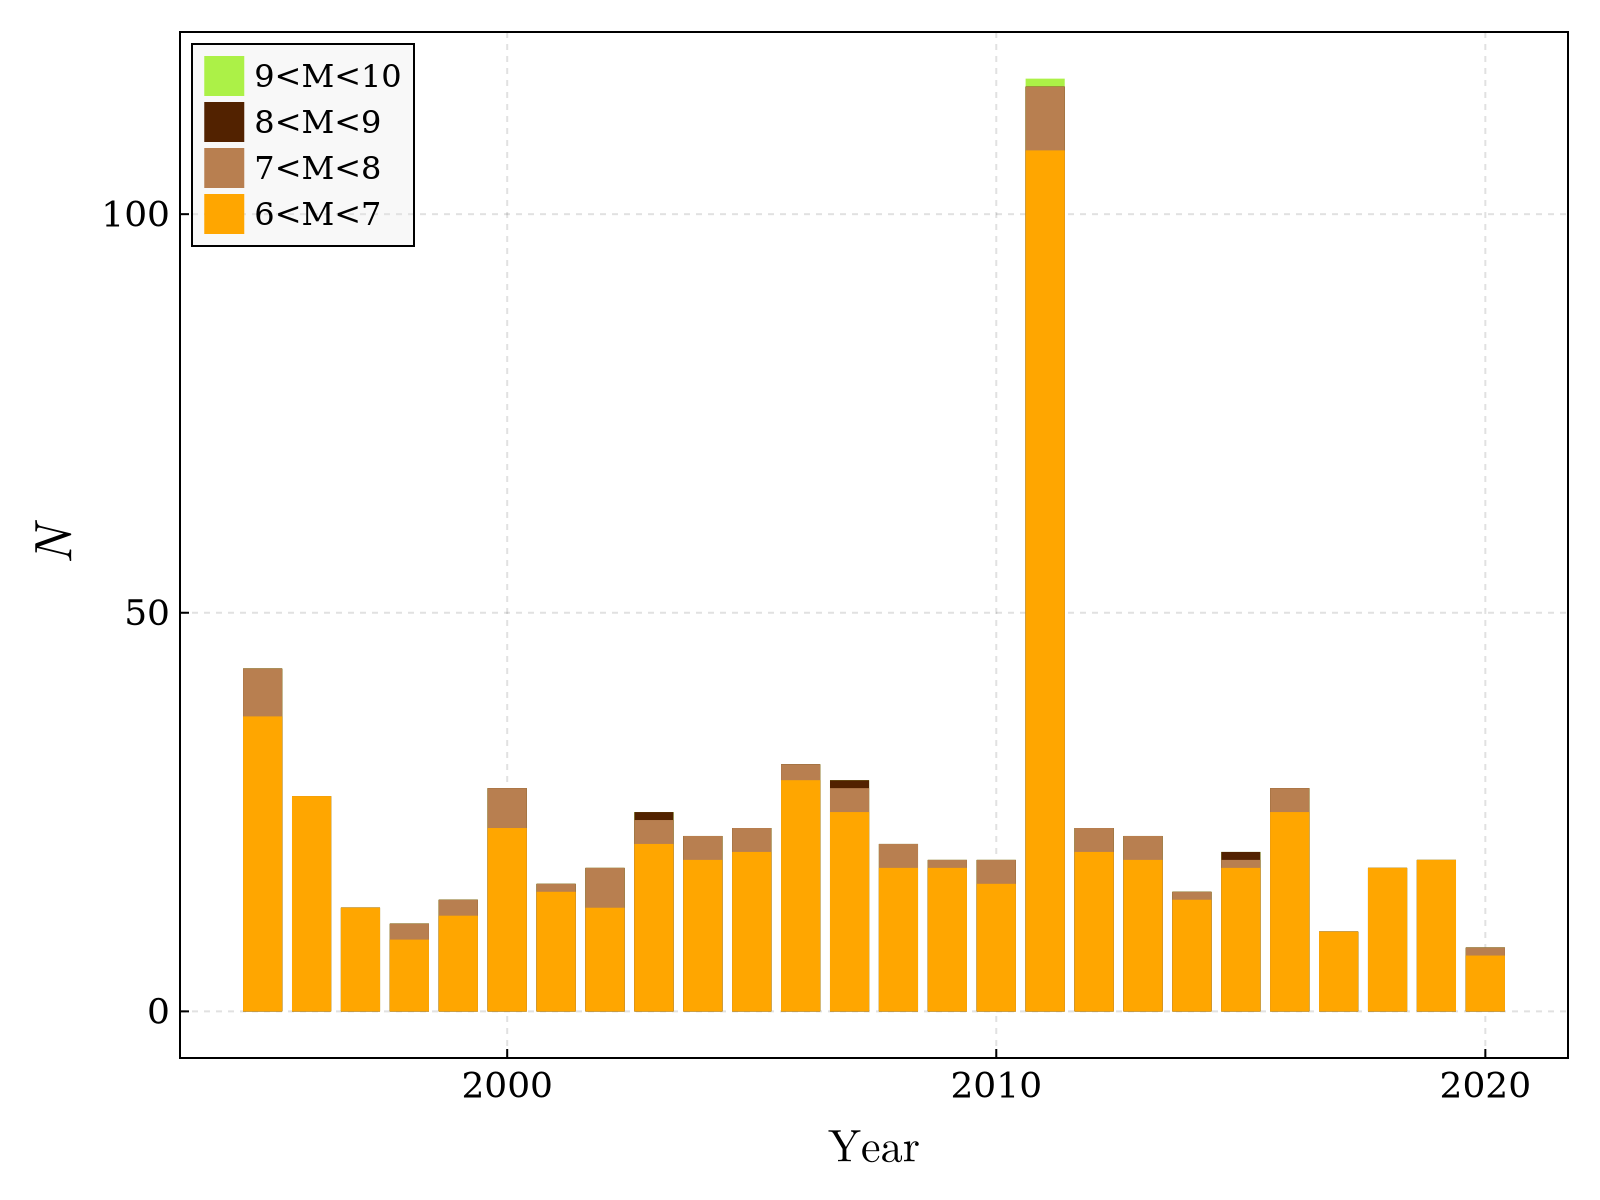

In [39]:
trim_year = 1995
magnitude_threshold = 6.0;

df_counted = join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold);

for minmag=Int(floor(minimum(df.Magnitude))):Int(floor(maximum(df.Magnitude)))
	maxmag=minmag+1
	df_counted_mag_extra = join_on_counted(df,trim_year,minmag,maxmag)

	leftjoin!(df_counted, df_counted_mag_extra, on=:Year, makeunique=true)
	df_counted[!,Symbol("count_mag_$minmag")] = replace(df_counted[!,Symbol("count_mag_$minmag")], missing => 0)
	if minmag>magnitude_threshold
		add_mag = minmag-1
		df_counted[!,Symbol("count_mag_$minmag")] = df_counted[!,Symbol("count_mag_$minmag")] .+ df_counted[!,Symbol("count_mag_$add_mag")]
	end
end


x = minimum(df_counted.Year):maximum(df_counted.Year)

colors=[:darkred, :orange, :green, :cyan, :midnightblue, :brown, :darkmagenta, :lime]
colors=["#ec111a", "#138468", "#009dd6", "#7cdd43",  "#7849b8", "#f2609e", "#ffa600", "#b87f50", "#522200", "#acf147", "#acf147"]

set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(size = (800, 600), font= "CMU Serif",) ## probably you need to install this font in your system


ax = Axis(fig[1, 1], xlabel = L"\mathrm{Year}", ylabel = L"N", ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1, xticklabelsize = 18, yticklabelsize = 18,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10)

for minmag=reverse(Int(floor(minimum(df.Magnitude))+magnitude_threshold):Int(floor(maximum(df.Magnitude))))
    maxmag=minmag+1
    barplot!(ax, x, df_counted[!,Symbol("count_mag_$minmag")], color=colors[maxmag], label ="$(minmag)<M<$(maxmag)" )
end

axislegend(ax, position = :lt, backgroundcolor = (:grey90, 0.25), labelsize=16);

if magnitude_threshold == 0.0
    save("./eda_results/$region/$(region)_events_per_year_mags.png",fig, px_per_unit=7)
elseif magnitude_threshold == 2.0
    save("./eda_results/$region/$(region)_events_per_year_mags_no_microearthquakes.png",fig, px_per_unit=7)
else
    save("./eda_results/$region/$(region)_events_per_year_mags_large.png",fig, px_per_unit=7)
end
fig
